## Spatial Tuning: Gabor Stimuli

This notebook corresponds to Section 3.4.1 of the thesis.
In the following, we analyse the recorded ROIs' spatial tuning to Gabor stimuli.


The computation and visualisation is based on code from a jupyter-notebook on visualising receptive fields, which can be found in the Allen Institute's OpenScope-Databook: https://alleninstitute.github.io/openscope_databook/first-order/receptive_fields.html (last accessed 12.09.2025)

### Step 1: Import Data and Dependencies

In [33]:
import warnings
warnings.filterwarnings('ignore')

try:
    from openscope_databook.databook_utils.dandi_utils import dandi_stream_open
except:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .

import sys
import os
#import nwb_utils
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import remfile
import h5py
import openscope_databook.databook_utils.dandi_utils

from dandi import dandiapi
from nwbwidgets import nwb2widget
import pynwb
from pynwb import NWBHDF5IO
from IPython.display import display, HTML

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import generic_filter

from scipy import interpolate


from helpers import *

%matplotlib inline

filepath = "sub-731327_ses-2025+01+30-vsync-new_ophys.nwb"

# Use NWBHDF5IO to read the local NWB file instead of dandi_stream_open
io = NWBHDF5IO(filepath, 'r')
nwb = io.read()
nwb
graphColour = (137/255, 0/255, 225/255)

gabor_stim_table = nwb.intervals["receptive_field_block_presentations_vsync"][:]
xs = np.sort(list(set(map(float, gabor_stim_table.x_position))))
ys = np.sort(list(set(map(float, gabor_stim_table.y_position))))[::-1]
planes = nwb.imaging_planes.keys()
orientations = sorted(gabor_stim_table["orientation"].unique())

### Step 2: Define Auxiliary Functions

In [34]:
# gets values of 8-connected pixels

def getSurrounding8(x, y):
    surrounding8 = []

    if x+1 < 9:
        surrounding8.append((x+1,y))
        if y+1 <9:
            surrounding8.append((x+1,y+1))
        if y-1 >0:
            surrounding8.append((x+1, y-1))

    if x-1>0:
        surrounding8.append((x-1, y))
        if y+1 <9:
            surrounding8.append((x-1,y+1))
        if y-1 >0:
            surrounding8.append((x-1, y-1))

    if y-1>0:
        surrounding8.append((x, y-1))

    if y+1<9:
        surrounding8.append((x, y+1))

    return surrounding8

In [35]:
# get local variance in an array

def getVar(arr):
    max_index = np.unravel_index(np.argmax(arr), arr.shape)
    arr[max_index] = arr.mean()
    return np.var(arr)

In [36]:
# get noise score of an RF

def getNoiseScore(rf_heat_map):

    local_variances = generic_filter(rf_heat_map, getVar, size=3)
    mean_local_var = np.mean(local_variances)
    return mean_local_var

In [37]:
# classify an RF as indicative of spatial tuning

def classifyRFmap(rf_heat_map):

    # first zscore
    mean = rf_heat_map.mean()
    std = rf_heat_map.std()
    rf_heat_map -= mean
    rf_heat_map /= std

    max_index = np.unravel_index(np.argmax(rf_heat_map), rf_heat_map.shape) # get maximum pixel

    surrounding9 = getSurrounding8(max_index[0], max_index[1])

    surroundresp = 0
    for coords in surrounding9:
        x = coords[0]
        y = coords[1]

        surroundresp += rf_heat_map[x,y]

    surroundresp /= len(surrounding9)
    noiseScore = getNoiseScore(rf_heat_map)
    
    if noiseScore < 0.50:
        if (noiseScore > 0.35) and (surroundresp >= 0.2 * rf_heat_map.max()):
            return True
        elif (noiseScore <= 0.35) and (surroundresp >= 0.1 * rf_heat_map.max()):
            return True
    elif ((surroundresp > 0.3 * rf_heat_map.max())):
        return True
    return False

In [38]:
# Computes and plots RF heat maps of a plane

def get_RF_heat_maps_for_plane(nwb, plane, stim_table, shift=0.2, plot=True):
    display_mask = getDisplayMask(stim_table)
    rf_heat_maps = []
    spatial_tuning_counter = 0

    dff_timestamps, dff_trace = get_dff_any(nwb, plane)
    dff_trace = interpolate_dff(dff_trace, dff_timestamps, 10) #always interpolate!
    dff_timestamps = np.arange(dff_timestamps[0], dff_timestamps[-1], step=(1/10))


    if plot:
        print(getRegionByPlane(plane))
        n_plots = dff_trace.shape[1]
        cols = 4
        rows = int(np.ceil(n_plots/cols))
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 2.4))
       
        axes = axes.flatten()



    for i in range(dff_trace.shape[1]):
        rf_heat_map = np.zeros((9,9), dtype=float)
        traces = dff_trace[:, i]
        for j in range(stim_table.shape[0]):

            x, y = getRFcoords(stim_table.iloc[j]["x_position"], stim_table.iloc[j]["y_position"])

            #first get indices
            start_time = stim_table.iloc[j]["start_time"] + shift # shift integration window
            end_time = stim_table.iloc[j]["stop_time"] + shift
            start_idx, end_idx = np.searchsorted(dff_timestamps, (start_time, end_time))
            rf_heat_map[y, x] += traces[start_idx:end_idx].mean()

        rf_heat_map /= display_mask

        rf_heat_maps.append(rf_heat_map)
        
        if plot:
            ax = axes[i]
            vmin, vmax = rf_heat_map.min(), rf_heat_map.max()
            img = ax.imshow(rf_heat_map, vmin=vmin, vmax=vmax, cmap='viridis')
            ax.set_title(f"ROI no.{i+1}")
            classbar = plt.colorbar(img, ax=ax, shrink=0.5)
            if i == 0:
                ax.set_xlabel("deg X")
                ax.set_ylabel("deg Y")
                ax.set_xticks(range(len(xs)), xs, rotation=90, fontsize=8)
                ax.set_yticks(range(len(ys)), ys, fontsize=8)
            else:
                ax.set_yticks([])
                ax.set_xticks([])

            if (i+1) % 8 == 0 and i < (rows-1) * 4:
                classbar.set_label("Location response ($\Delta$F/F)")

            if classifyRFmap(rf_heat_map) == True:  # label spatially tuned ROIs
                spatial_tuning_counter += 1
                for spine in ax.spines.values():
                    spine.set_edgecolor(graphColour)
                    spine.set_linewidth(3) 

    # hide unused subplots
    if plot: 
        for k in range(n_plots, len(axes)):
            fig.delaxes(axes[k])

        plt.tight_layout()
        fig.subplots_adjust(bottom=0.05)  
        print(f"Detected {spatial_tuning_counter} spatially tuned ROIs in {getRegionByPlane(plane)} imaging plane")
        _ = plt.show()
    
    rf_heat_maps = np.array(rf_heat_maps)
    return rf_heat_maps

In [39]:
# computes RF heat map of specific ROI

def getSingleRF_heat_map(roi, dff_trace, dff_timestamps, stim_table, onset=0.2):
    rf_heat_map = np.zeros((9,9), dtype=float)
    display_mask = getDisplayMask(stim_table)
    traces = dff_trace[:, roi]
    for j in range(stim_table.shape[0]):

        x, y = getRFcoords(stim_table.iloc[j]["x_position"], stim_table.iloc[j]["y_position"])

        #first get indices
        start_time = stim_table.iloc[j]["start_time"] + onset
        end_time = stim_table.iloc[j]["stop_time"] + onset
        start_idx, end_idx = np.searchsorted(dff_timestamps, (start_time, end_time))
        
        rf_heat_map[y, x] += traces[start_idx:end_idx].mean()

    rf_heat_map /= display_mask

    return rf_heat_map


In [40]:
# Computes summed RF heat map of a specific imaging plane

def get_summed_RF_heat_map_for_plane(nwb, plane, stim_table, onset=0.2, account_for_roi_amount=False):
    display_mask = getDisplayMask(stim_table)
    rf_heat_maps = []

    dff_timestamps, dff_trace = get_dff_any(nwb, plane)
    dff_trace = interpolate_dff(dff_trace, dff_timestamps, 10) #always interpolate
    dff_timestamps = np.arange(dff_timestamps[0], dff_timestamps[-1], 1/10)

    for i in range(dff_trace.shape[1]): #for every roi
        rf_heat_map = np.zeros((9,9), dtype=float)
        traces = dff_trace[:, i]
        for j in range(stim_table.shape[0]):

            x, y = getRFcoords(stim_table.iloc[j]["x_position"], stim_table.iloc[j]["y_position"])

            #first get indices
            start_time = stim_table.iloc[j]["start_time"] + onset
            end_time = stim_table.iloc[j]["stop_time"] + onset
            start_idx, end_idx = np.searchsorted(dff_timestamps, (start_time, end_time))

            rf_heat_map[y, x] += traces[start_idx:end_idx].sum()

        rf_heat_map /= display_mask

        rf_heat_maps.append(rf_heat_map)
    
    rf_heat_maps = np.array(rf_heat_maps)

    if account_for_roi_amount:
        rf_heat_map_for_plane = rf_heat_maps.sum(axis=0) / dff_trace.shape[1]
    else:
        rf_heat_map_for_plane = rf_heat_maps.sum(axis=0)
    return rf_heat_map_for_plane

### Step 3: Compute RF Heat Maps

In [ ]:
# Compute summed RF heat maps
summed_rf_heat_maps = np.zeros((len(planes), 4, 9, 9))

for row_idx, plane in enumerate(planes):
    for col_idx, orientation in enumerate(orientations):
        stim_table = gabor_stim_table[gabor_stim_table["orientation"]==orientation]   

        rf_heat_map = get_summed_RF_heat_map_for_plane(nwb, plane, stim_table, account_for_roi_amount=True)
        summed_rf_heat_maps[row_idx, col_idx+1, :, :] = rf_heat_map # RF heat map for one orientation

    rf_heat_map = get_summed_RF_heat_map_for_plane(nwb, plane, gabor_stim_table, account_for_roi_amount=True) # RF hat map for all orientations
    summed_rf_heat_maps[row_idx, 0, :, :] = rf_heat_map

### Step 4: Visualise RF Heat Maps

Summed RF heat maps:

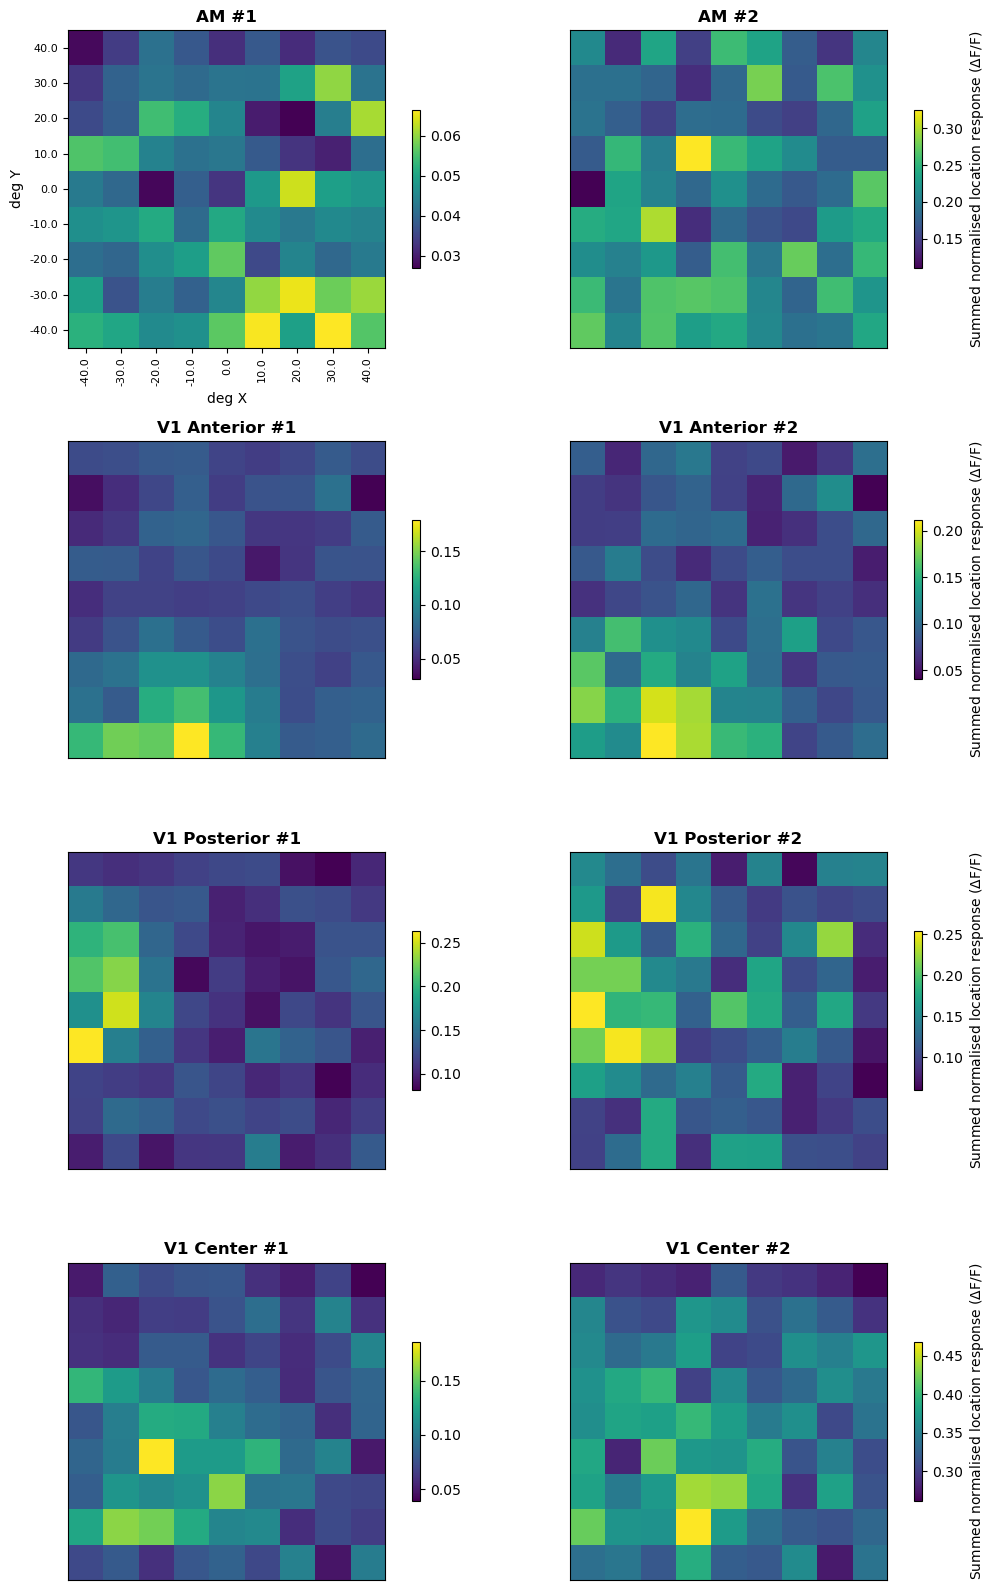

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(11, 16))
axes = axes.flatten()

for i, plane in enumerate(planes):
    ax = axes[i]

    ax.set_title(f"{getRegionByPlane(plane)}", fontweight='bold')

    total_rf_heat_map = summed_rf_heat_maps[i, 0, :, :]
    vmax = total_rf_heat_map.max()
    vmin = total_rf_heat_map.min()

    imshow  = ax.imshow(total_rf_heat_map, cmap="viridis", vmin=vmin, vmax=vmax)
    ax.set_xticks([])
    ax.set_yticks([])
    cbar = fig.colorbar(imshow, ax=ax, shrink=0.5)
       
    if i % 2 != 0:
        cbar.set_label("Summed normalised location response ($\Delta$F/F)")
    
    if i == 0:
        ax.set_xlabel("deg X")
        ax.set_ylabel("deg Y")
        ax.set_xticks(range(len(xs)), xs, rotation=90, fontsize=8)
        ax.set_yticks(range(len(ys)), ys, fontsize=8)
  
plt.tight_layout()
_ = plt.show()

Summed RF heat maps by orientation:

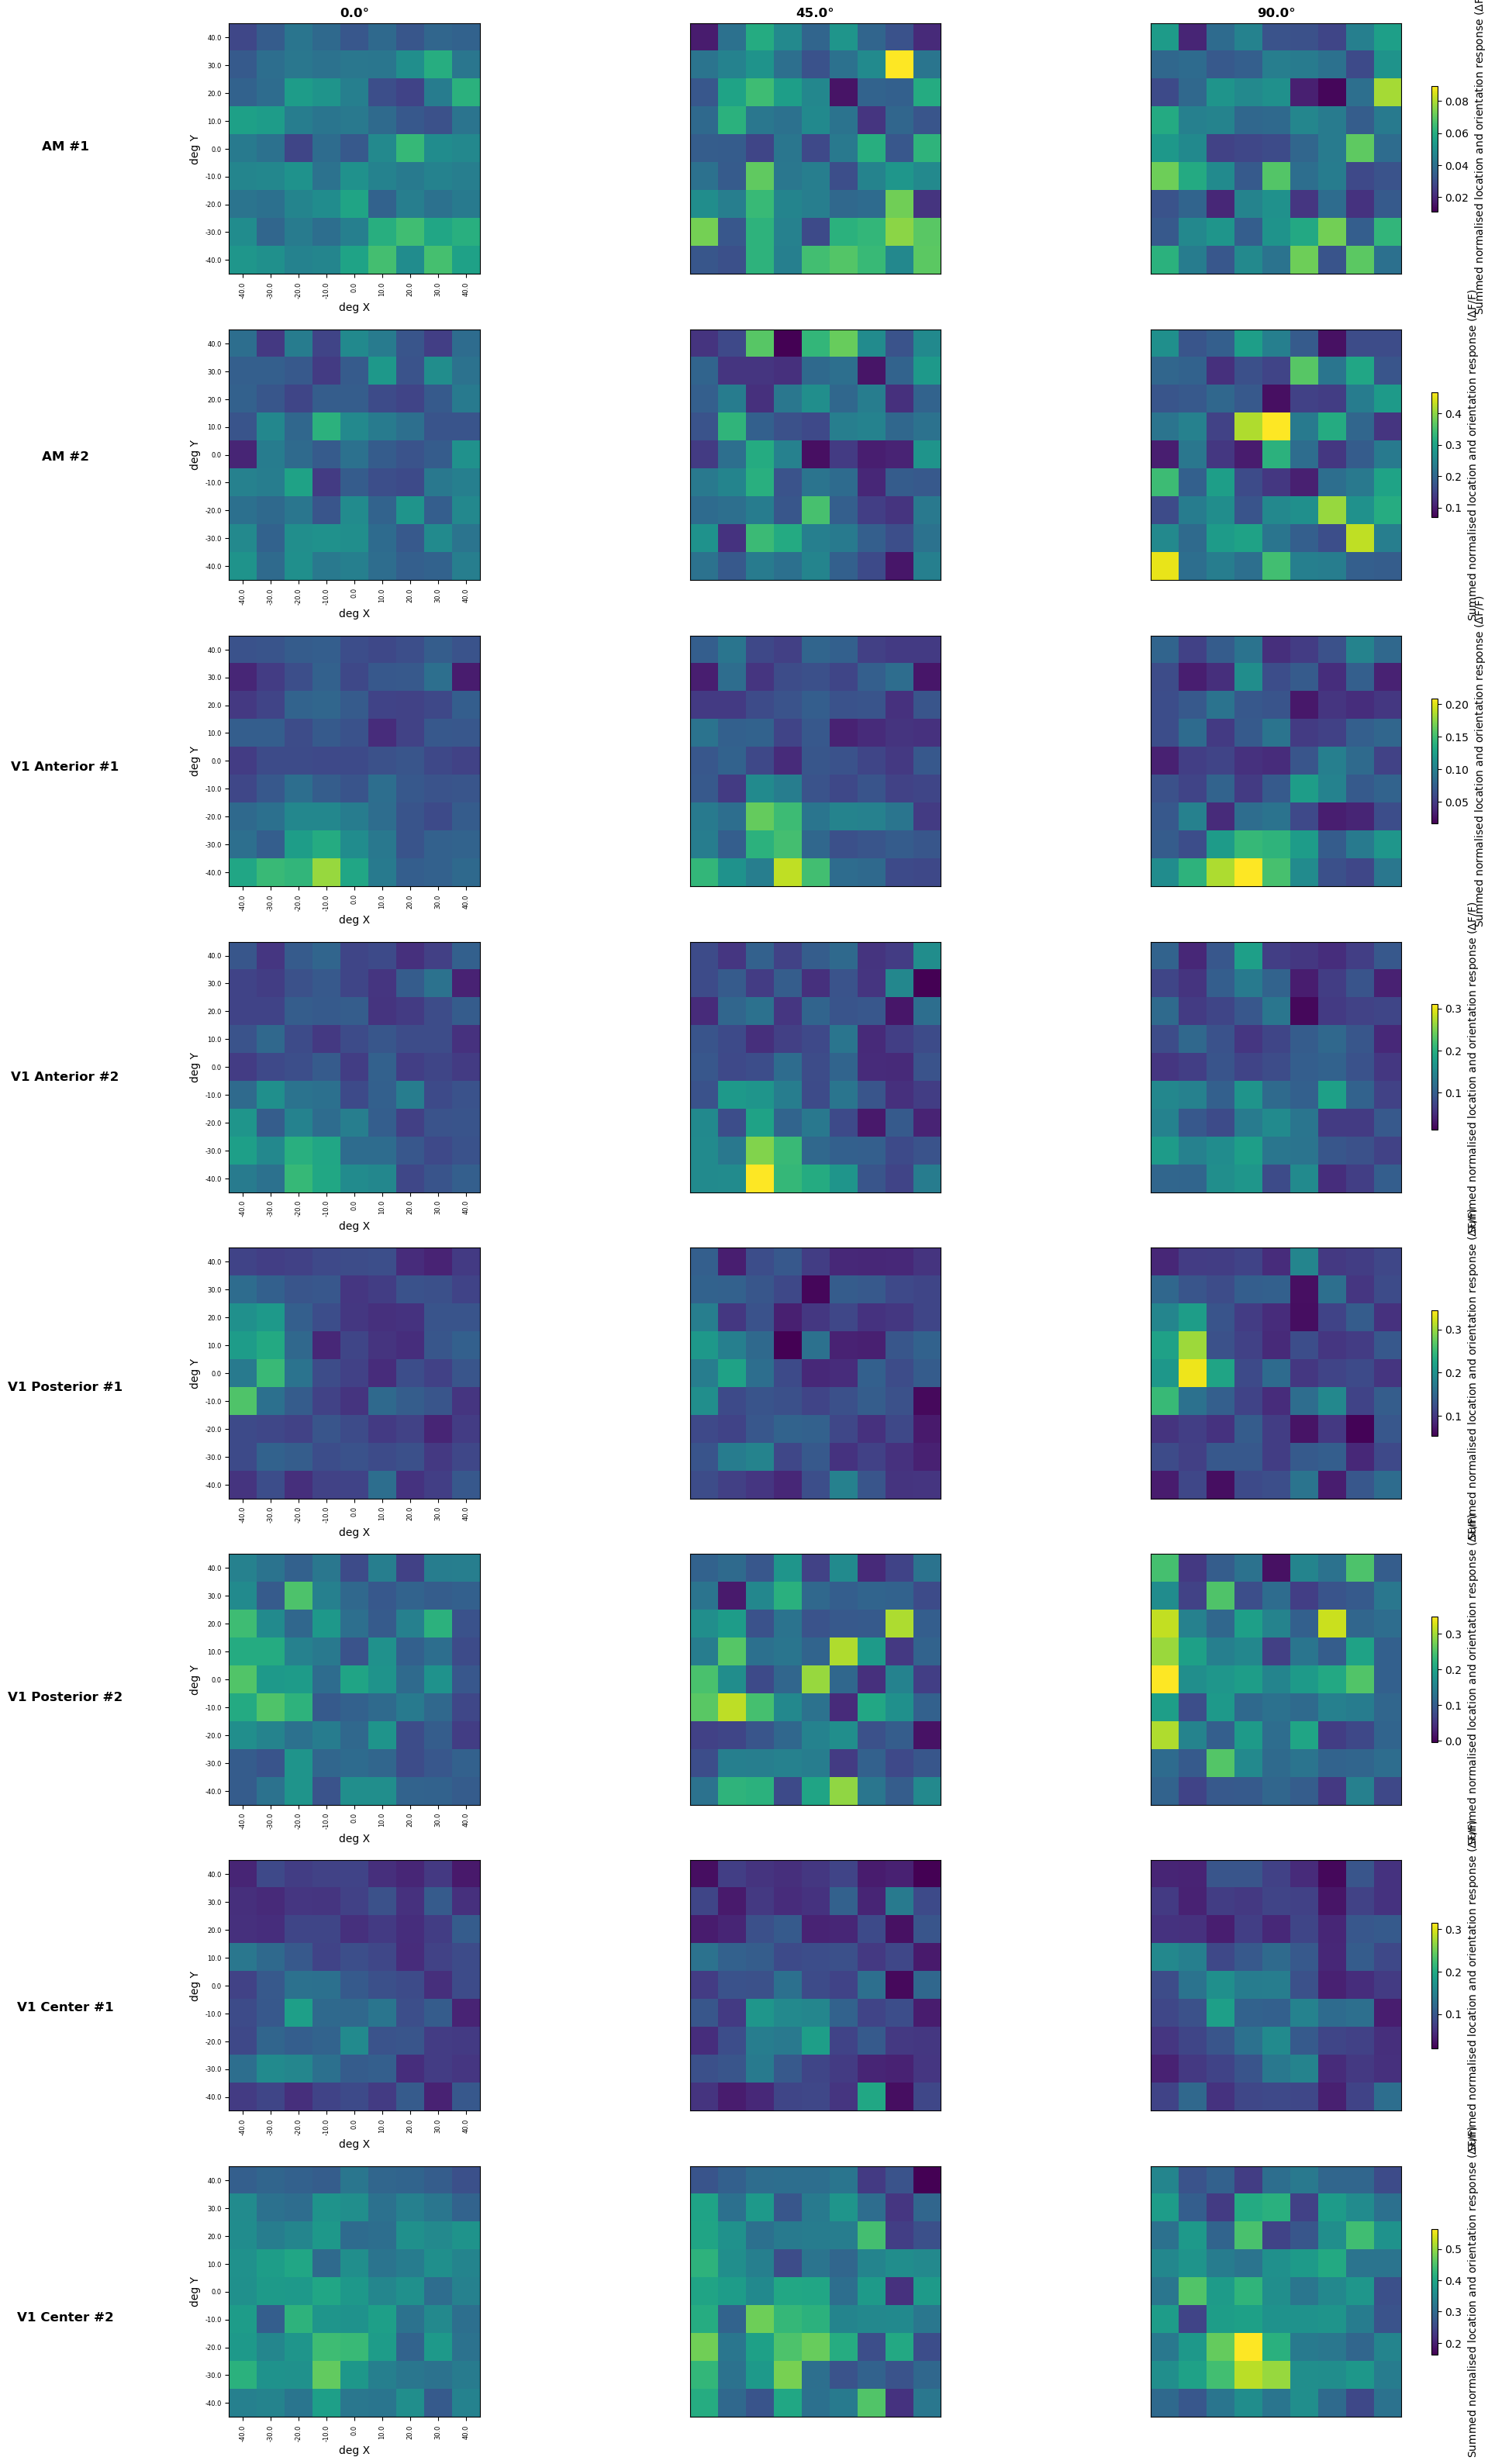

In [ ]:
fig, axes = plt.subplots(len(planes), 3, figsize=(20, 4 * len(planes)))

for i, plane in enumerate(planes):
    fig.text(0.05, 1 - (0.0625 + i * 0.125), getRegionByPlane(plane), ha='center', va='center', fontsize=12, fontweight='bold')

    plane_rf_heat_maps = np.stack([summed_rf_heat_maps[i, 1, :, :], summed_rf_heat_maps[i, 2, :, :], summed_rf_heat_maps[i, 3, :, :]])
    
    vmax = plane_rf_heat_maps.max()
    vmin = plane_rf_heat_maps.min()

    for j, orientation in enumerate(orientations):
        imshow = axes[i,j].imshow(summed_rf_heat_maps[i, j, :, :], cmap="viridis", vmin=vmin, vmax=vmax)
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])
        
        if i == 0:
            axes[i,j].set_title(f"{orientation}°", fontweight='bold')

        if j == 0:
            axes[i,j].set_xlabel("deg X")
            axes[i,j].set_ylabel("deg Y")
            axes[i,j].set_xticks(range(len(xs)), xs, rotation=90, fontsize=6)
            axes[i,j].set_yticks(range(len(ys)), ys, fontsize=6)

        if j == 2:
            cbar = fig.colorbar(imshow, ax=axes[i,j], shrink=0.5)
            cbar.set_label("Summed normalised location and orientation response ($\Delta$F/F)")
        else:
            cbar = fig.colorbar(imshow, ax=axes[i,j], shrink=0.5)
            cbar.ax.set_visible(False)
            
plt.tight_layout(pad = 1.5)
_ = plt.show()

Exemplary RF heat map types presented in thesis:

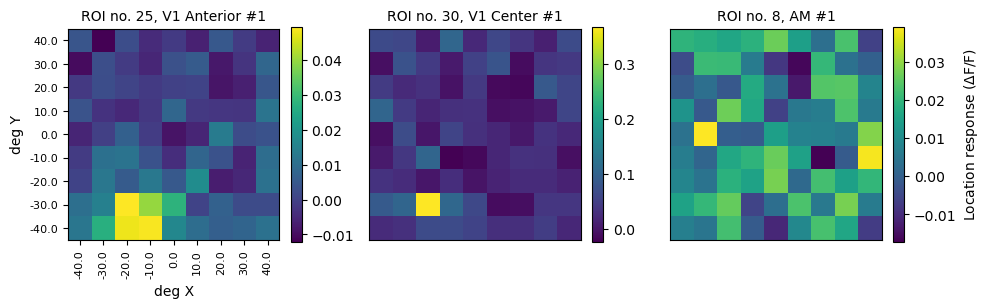

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(10,7))
axes = axes.flatten()

rfs_locations = [(24, "VISp_0"), (29, "VISp_4"), (7, "VISam_6")]

for idx, loc in enumerate(rfs_locations):
    roi = loc[0]
    plane = loc[1]

    ax = axes[idx]
    dff_timestamps, dff_traces = get_dff_any(nwb, plane)
    dff_traces = interpolate_dff(dff_traces, dff_timestamps, 10)
    dff_timestamps = np.arange(dff_timestamps[0], dff_timestamps[-1], 1/10)
    rf = getSingleRF_heat_map(roi, dff_traces, dff_timestamps, gabor_stim_table)

    vmin, vmax = rf.min(), rf.max() # adjust these to change contrast of fluorescence values in the plot
    img = ax.imshow(rf, vmin=vmin, vmax=vmax, cmap='viridis')
    ax.set_title(f"ROI no. {roi+1}, {getRegionByPlane(plane)}", fontsize=10)
    classbar = plt.colorbar(img, ax=ax, fraction=0.046)
    
    if idx == 0:
        xs = np.sort(list(set(map(float, gabor_stim_table.x_position))))
        ys = np.sort(list(set(map(float, gabor_stim_table.y_position))))[::-1]

        ax.set_xlabel("deg X")
        ax.set_ylabel("deg Y")
        ax.set_xticks(range(len(xs)), xs, rotation=90, fontsize=8)
        ax.set_yticks(range(len(ys)), ys, fontsize=8)
    else:
        ax.set_yticks([])
        ax.set_xticks([])

    if idx == 2:
        classbar.set_label("Location response ($\Delta$F/F)")

plt.tight_layout()
_ = plt.show()


RF heat maps of all ROIs individually:

AM #1
Detected 8 spatially tuned ROIs in AM #1 imaging plane


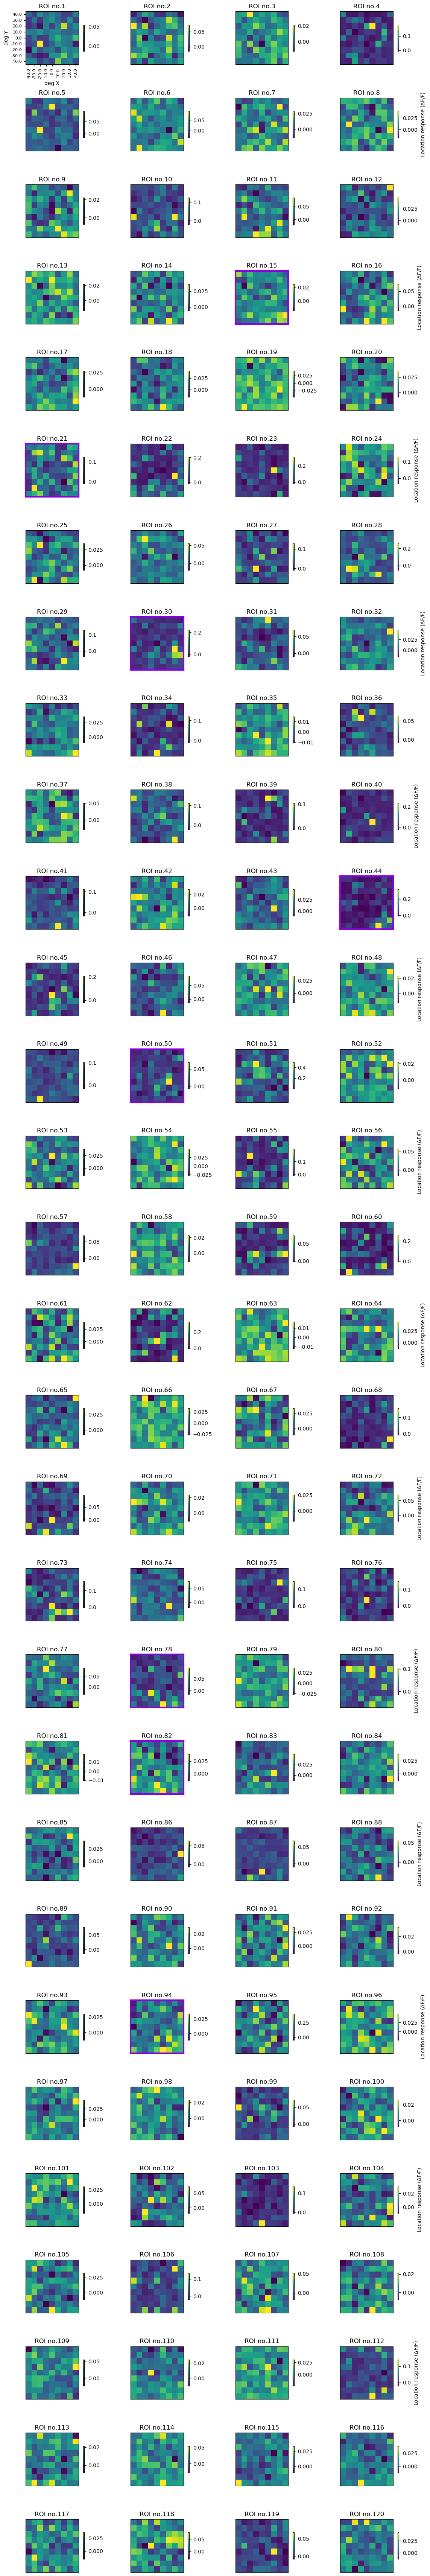

AM #2
Detected 5 spatially tuned ROIs in AM #2 imaging plane


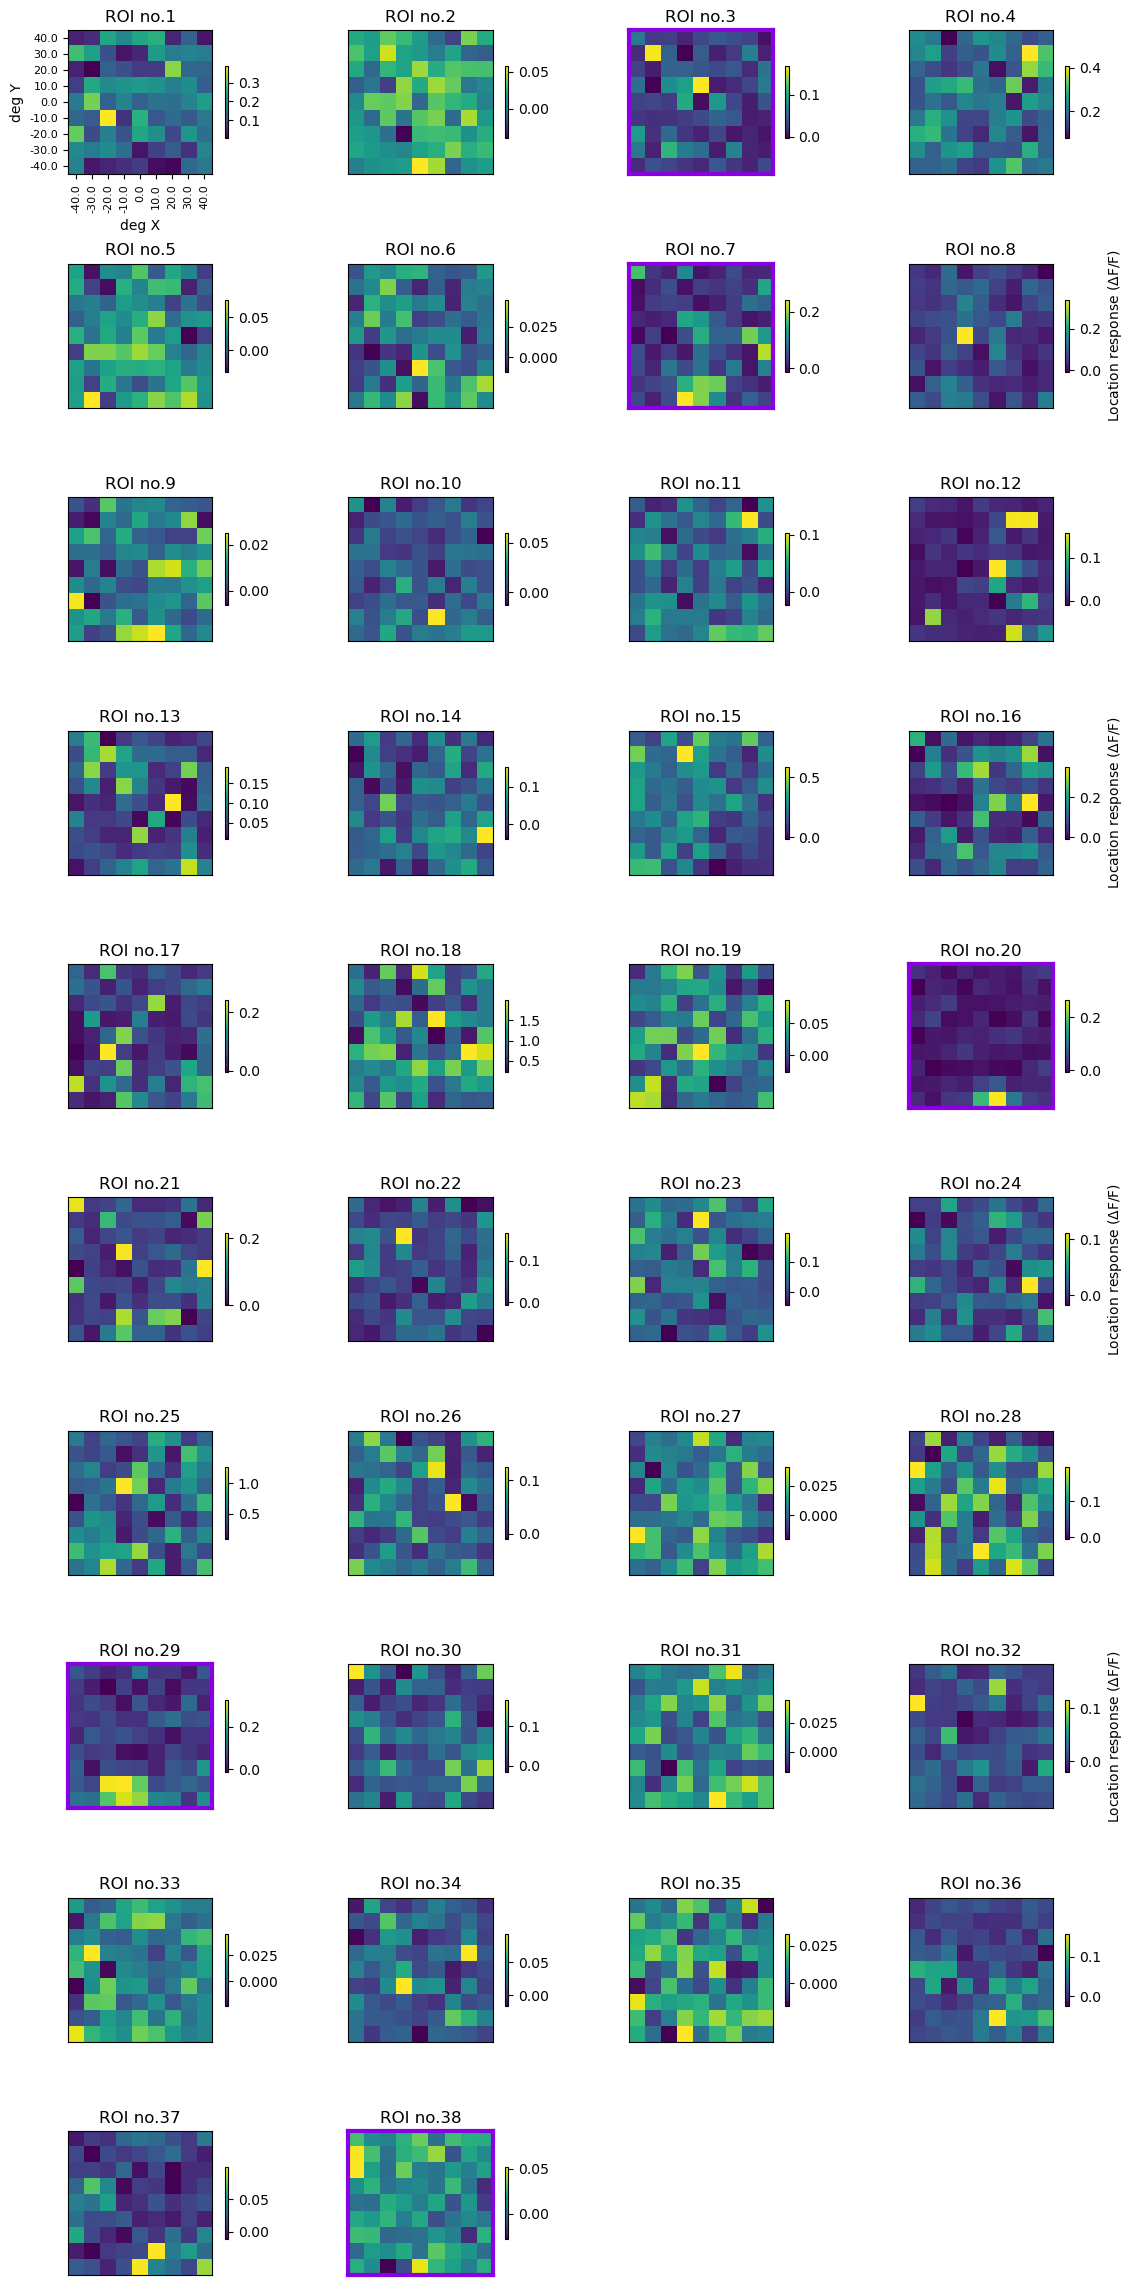

V1 Anterior #1
Detected 46 spatially tuned ROIs in V1 Anterior #1 imaging plane


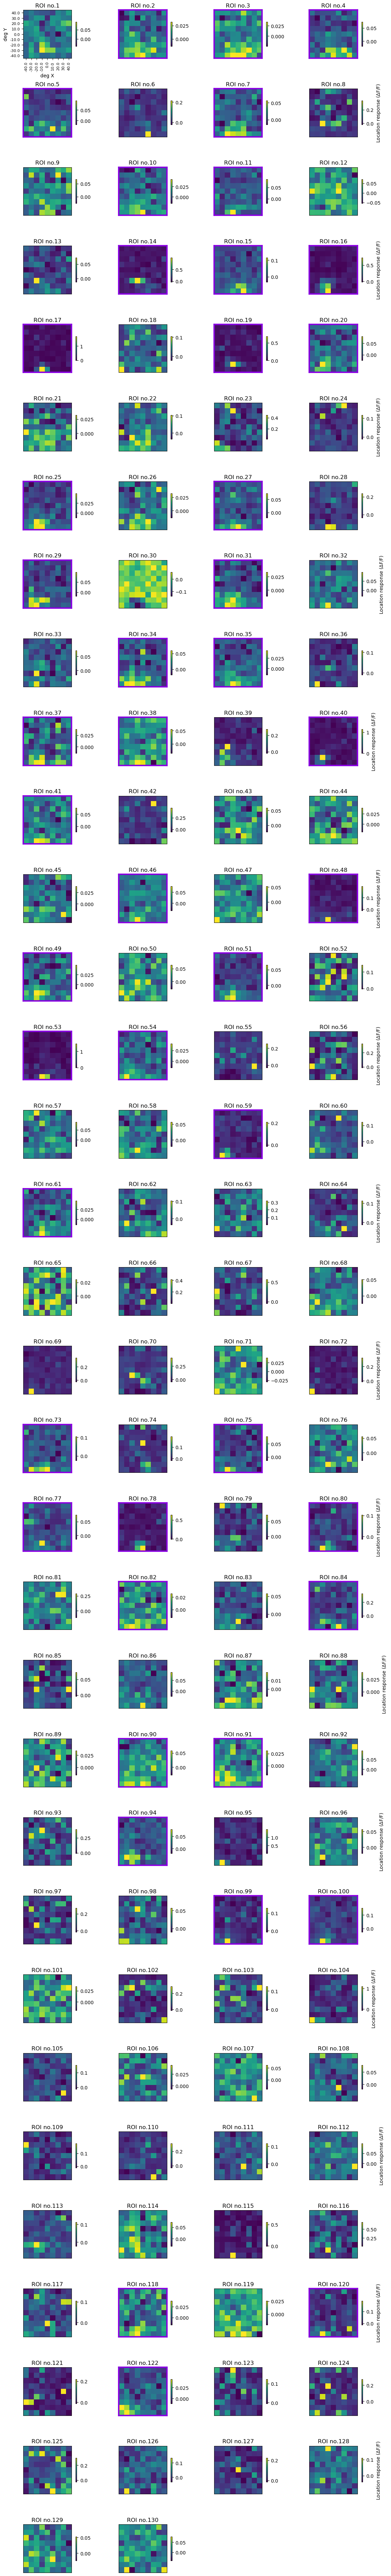

V1 Anterior #2
Detected 22 spatially tuned ROIs in V1 Anterior #2 imaging plane


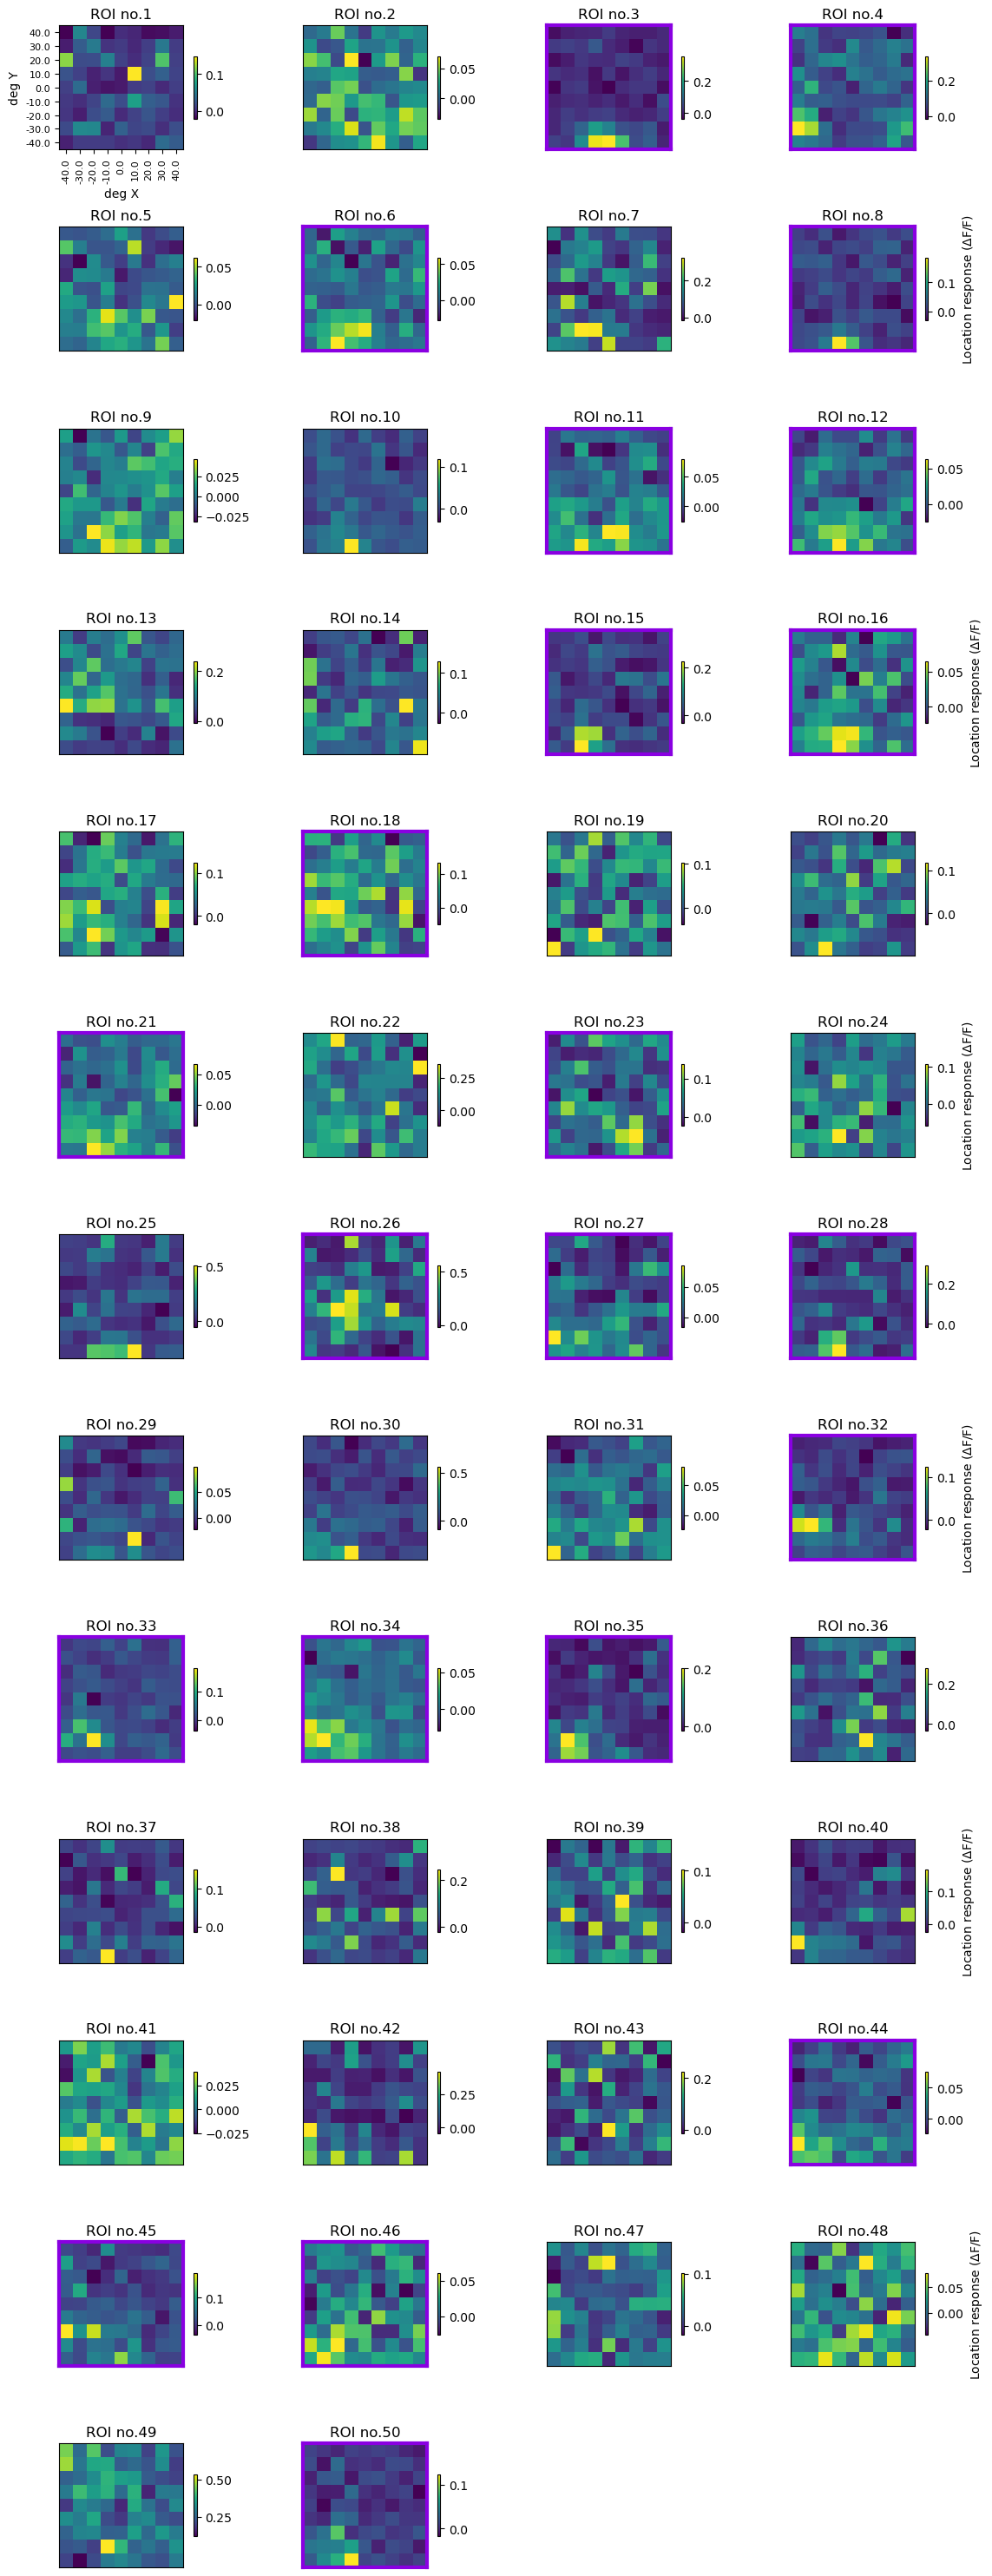

V1 Posterior #1
Detected 41 spatially tuned ROIs in V1 Posterior #1 imaging plane


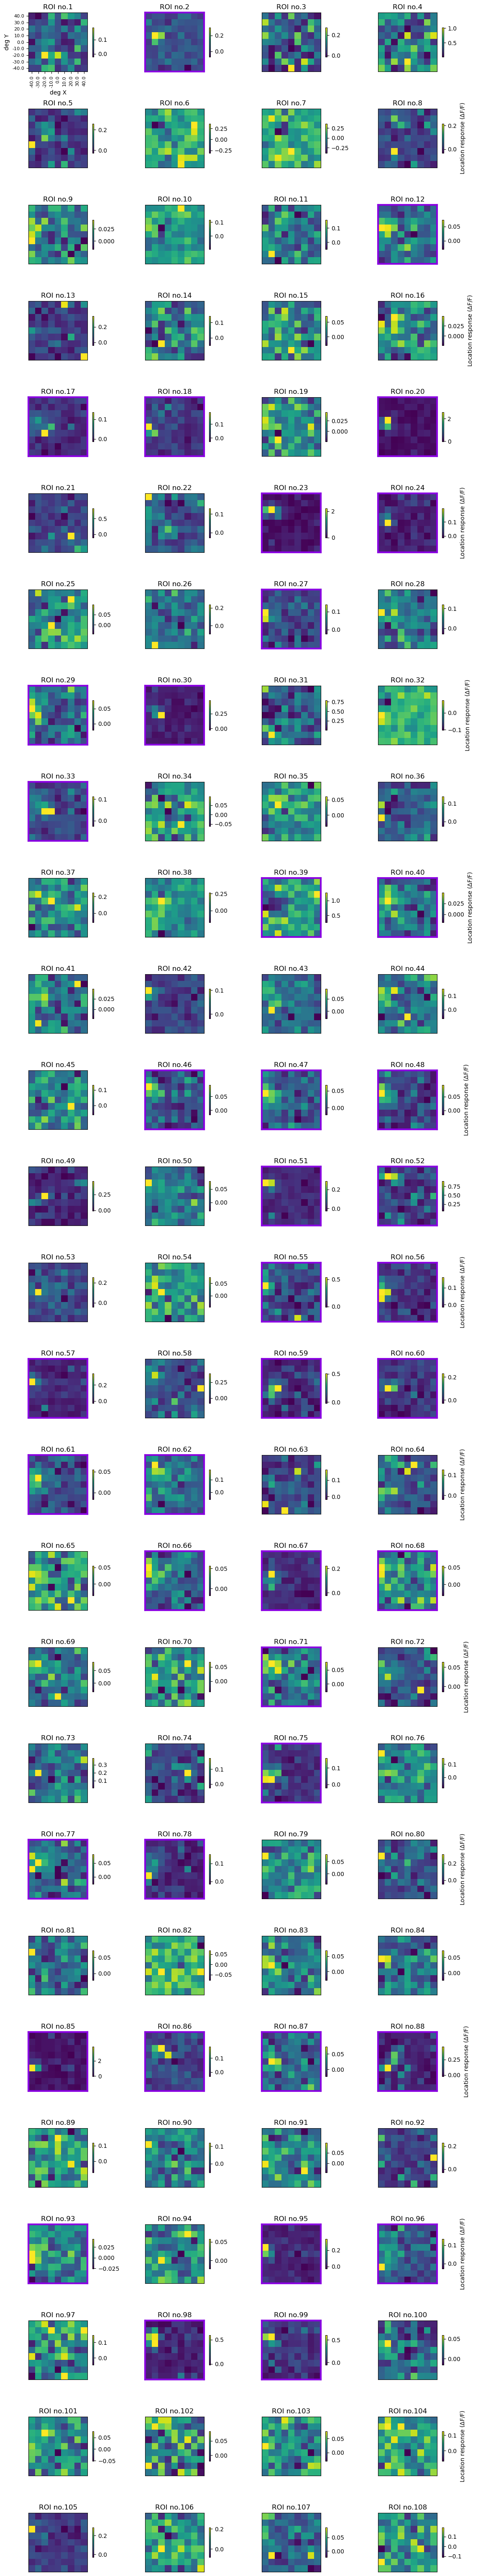

V1 Posterior #2
Detected 11 spatially tuned ROIs in V1 Posterior #2 imaging plane


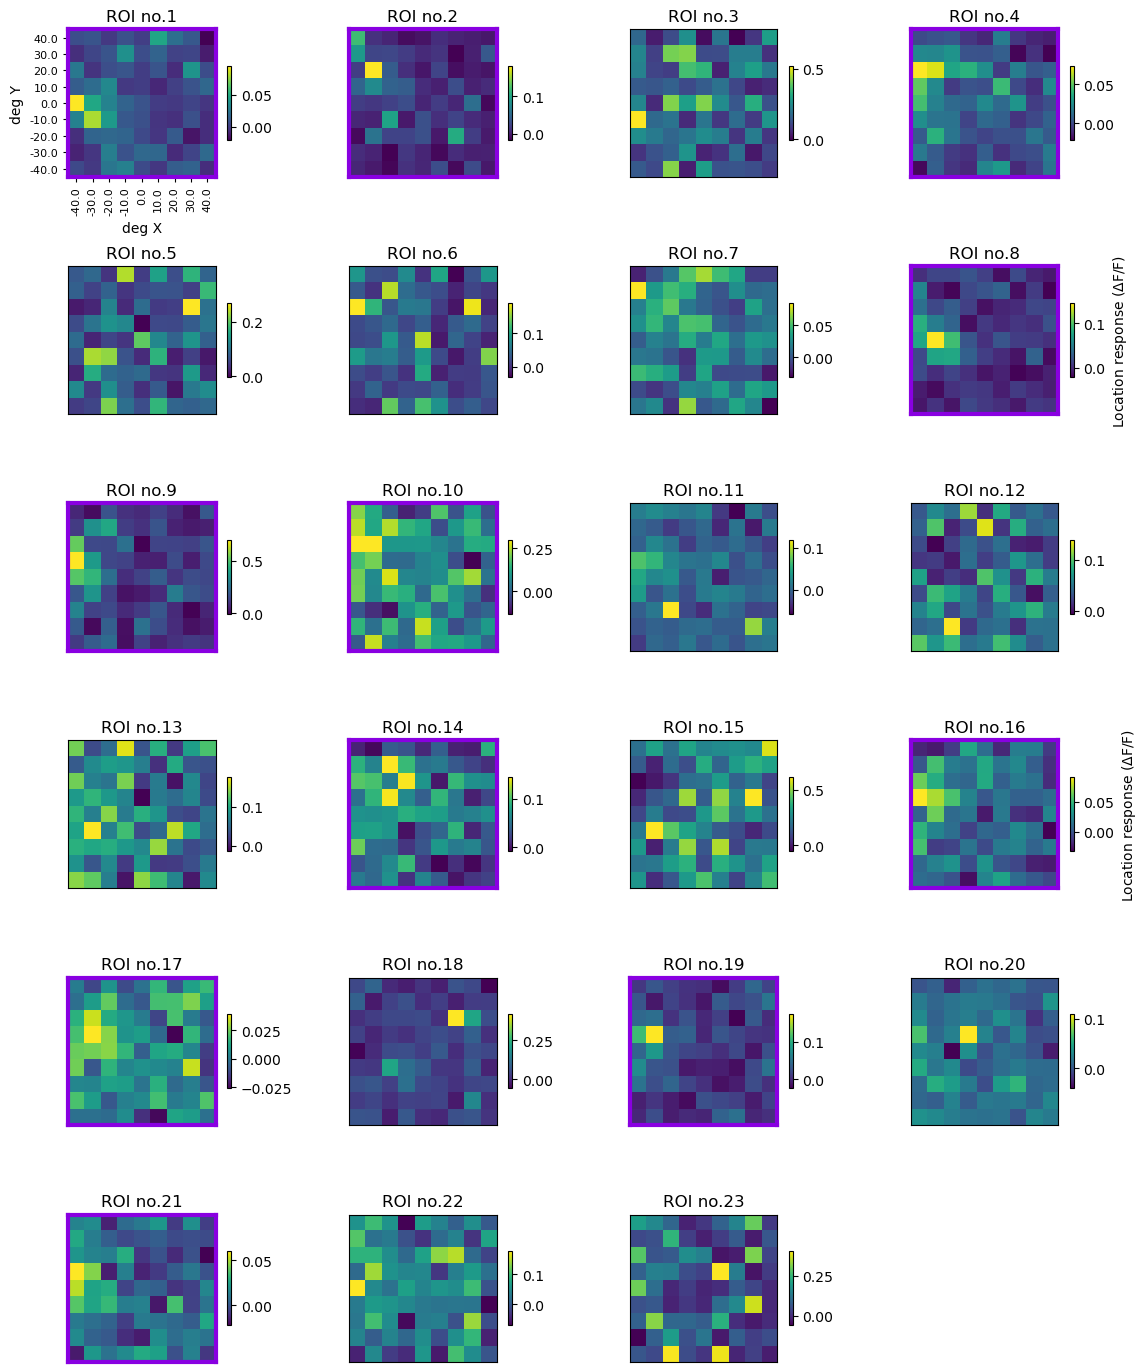

V1 Center #1
Detected 28 spatially tuned ROIs in V1 Center #1 imaging plane


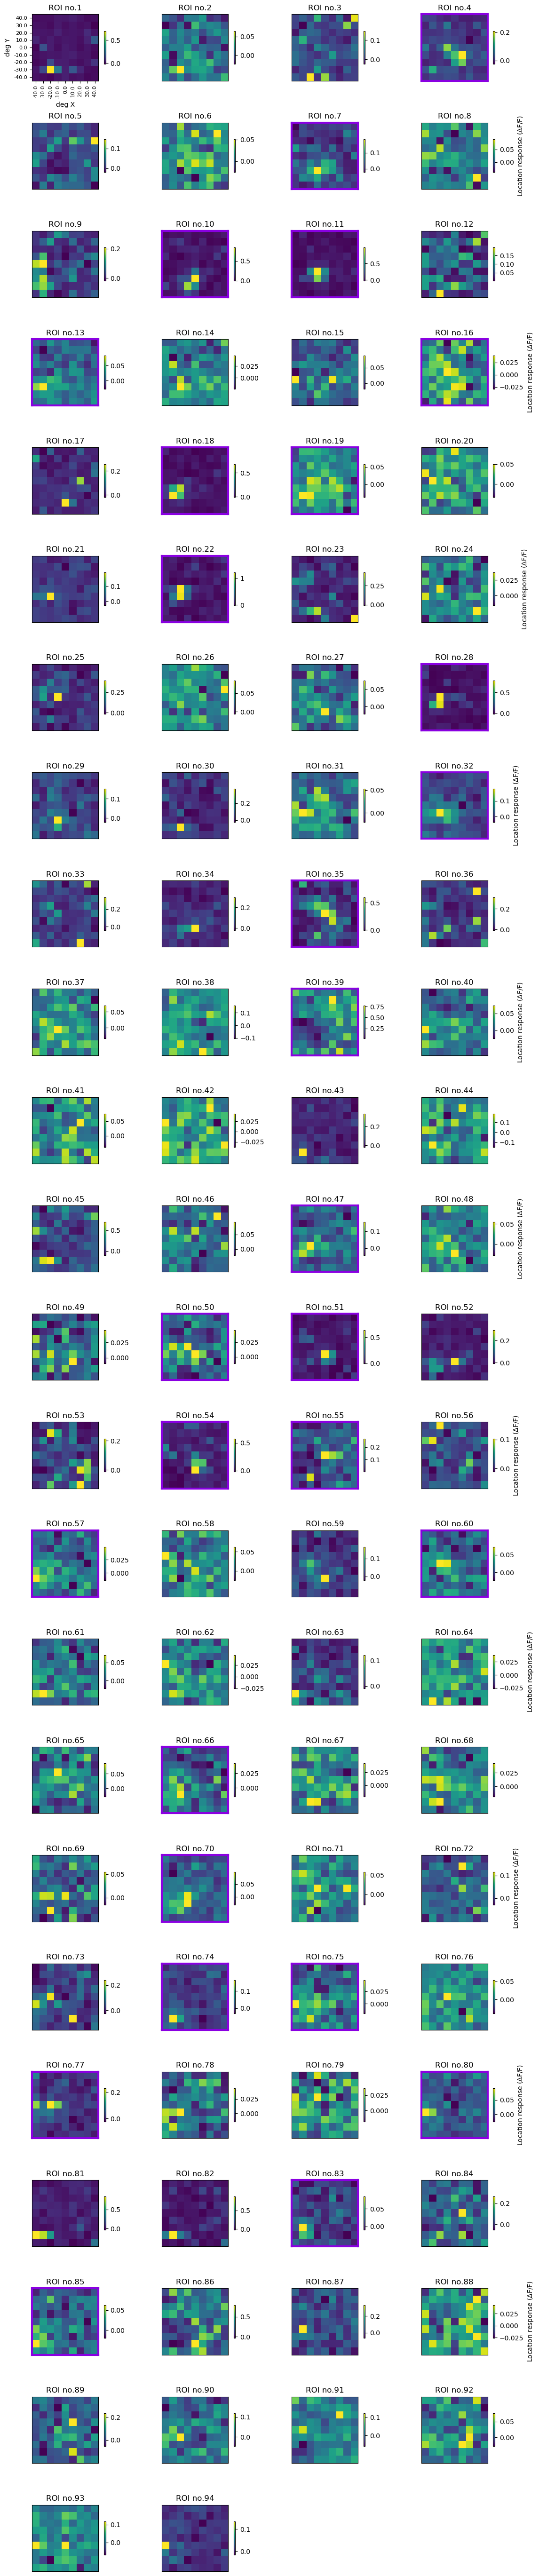

V1 Center #2
Detected 13 spatially tuned ROIs in V1 Center #2 imaging plane


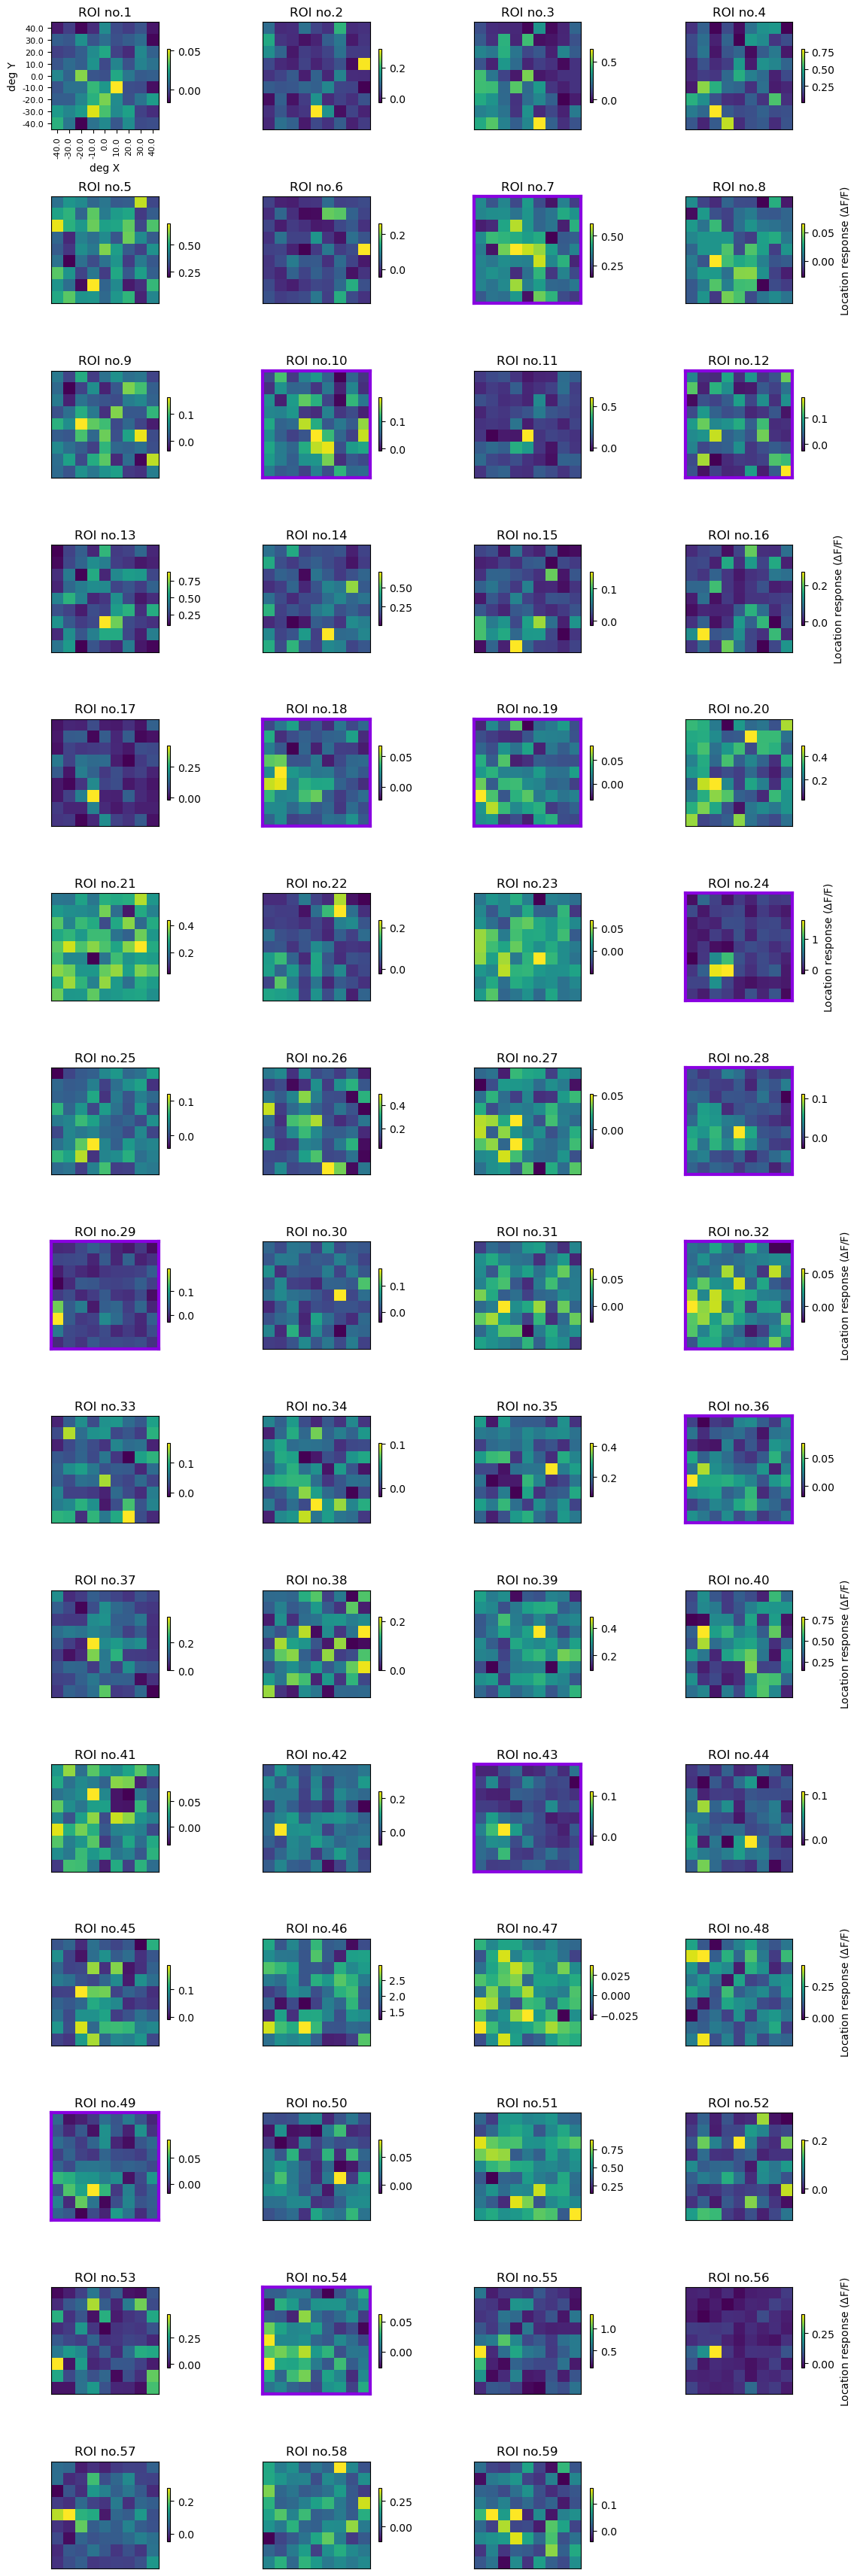

In [ ]:
for _ , plane in enumerate(nwb.imaging_planes.keys()):
    get_RF_heat_maps_for_plane(nwb, plane, gabor_stim_table)